## 0. Import required packages and define helper functions
### CIFAR-10 is an image dataset. In order to wrestle with classifying images using SVM, we need external packages as followed:

In [14]:
# Basic packages
import time
import pickle
import numpy as np
# Sci-kit Learn
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
# Sci-kit Image
from skimage.feature import hog
from skimage.color import rgb2gray
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
# Visualization
import matplotlib.pyplot as plt
import matplotlib as mpl
# Helpers
def unpickle(file):
    with open(file, 'rb')as fo:
        output_dict =pickle.load(fo, encoding='bytes')
    return output_dict

## 1. Pre-processing images for SVM
### Compared to CNN, classifying images using SVM requires utilization of a feature descriptor to extract features during pre-processing. Here we use both gray-scale HOG features and flatten color features to keep as much valuable info regarding the images as we can.

### Take one image as an example

In [2]:
directory_name = "C:\\Users\\w00536811\\Desktop\\WYYassignment\\cifar-10-batches-py\\"
file_name = directory_name + "data_batch_1"

raw_demo_image = unpickle(file_name)[b'data'][1]
len(raw_demo_image)

3072

### Tensor transformation

In [3]:
# re-format raw data to RGB format as a 32 by 32 by 3 Tensor (H, W, C)
rgb_demo_image = np.zeros((32,32,3),dtype=np.uint8)  # use uint8 consistently
# To speed up this transformation, use the data order in memory of the raw data for iteration
# channel -> row -> column
for k in range(3):  # C
    for i in range(32):  # H
        for j in range(32):  # W
            rgb_demo_image[i][j][k] = raw_demo_image[k*1024+i*32+j]

### Original image and grey-scaled

(32, 32, 3)


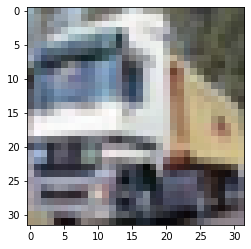

In [4]:
print(rgb_demo_image.shape)
plt.imshow(rgb_demo_image)
plt.show()

(32, 32)


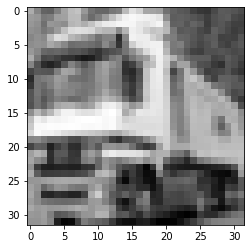

In [5]:
grey_demo_image = rgb2gray(rgb_demo_image)
print(grey_demo_image.shape)
plt.imshow(grey_demo_image, cmap=mpl.cm.gray)  # color mapping (cmap): gray mapping 
plt.show()

### HOG features: histogram of oriented gradients

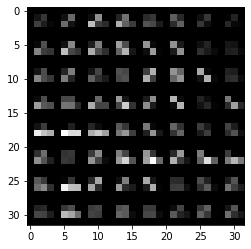

In [6]:
hog_features, hog_image = hog(grey_demo_image, visualize=True, block_norm='L2-Hys', pixels_per_cell=(4, 4))

plt.imshow(hog_image, cmap=mpl.cm.gray)
plt.show()

### Create features for each image: the concatenation of gray HOG and color features

In [7]:
color_features = rgb_demo_image.flatten()
print(hog_features.shape)
print(color_features.shape)
demo_features = np.hstack((hog_features, color_features))
print(demo_features.shape)

(2916,)
(3072,)
(5988,)


### Perform such pre-processing for all images in one batch

In [8]:
feature_matrix = []
for image in unpickle(file_name)[b'data']:
    rgb_image = np.zeros((32,32,3), dtype=np.uint8)
    for k in range(3):  # C
        for i in range(32):  # H
            for j in range(32):  # W
                rgb_image[i][j][k] = image[k*1024+i*32+j]
    grey_image = rgb2gray(rgb_image)
    hog_features = hog(grey_image, visualize=False, block_norm='L2-Hys', pixels_per_cell=(4, 4))
    color_features = rgb_image.flatten()
    flatten_features = np.hstack((hog_features, color_features))
    feature_matrix.append(flatten_features)

### We now have 5988 features for each image. To speed up kernel SVM, we need to reduce the number of features. Here we choose PCA to do so. 
### We also conduct scaling here.

In [9]:
ss = StandardScaler()
feature_matrix = ss.fit_transform(feature_matrix)

pca = PCA(n_components=500)
demo_feature_matrix = pca.fit_transform(feature_matrix)

print("Dimension after reduction: {}".format(demo_feature_matrix.shape))

Dimension after reduction: (10000, 500)


### Each sample has 500 scaled features after Scaling and PCA.

## 2. Encapsulate all pre-processing steps above in one function

In [10]:
def preprocess(data_to_process):
    feature_matrix = []
    
    for image in data_to_process:
        rgb_image = np.zeros((32,32,3), dtype=np.uint8)
        for k in range(3):  
            for i in range(32):  
                for j in range(32):  
                    rgb_image[i][j][k] = image[k*1024+i*32+j]
        
        grey_image = rgb2gray(rgb_image)
        hog_features = hog(grey_image, visualize=False, block_norm='L2-Hys', pixels_per_cell=(4, 4))
        color_features = rgb_image.flatten()
        flatten_features = np.hstack((hog_features, color_features))
        
        feature_matrix.append(flatten_features)
    
    ss = StandardScaler()
    feature_matrix = ss.fit_transform(feature_matrix)
    pca = PCA(n_components=500)
    feature_matrix = pca.fit_transform(feature_matrix)
    
    return feature_matrix

## 3. Train bagging classifiers using kernel SVM classifiers as base clf and perform cross validation
### The original dataset is split into 6 batches with stratification. Hence we will conduct cross validation using these 6 batches by concatenating 5 of them as training set and the rest for testing.
### We choose not to train one SVM from these 50000 samples. The reason is the computational expensiveness of kernel SVM when it comes to too many samples. Training complexity of SVM is O(n_features x n_samples^3), making training classifiers with more than a score of thousands of samples impractical.
### Instead, we opt to use bagging by training 50 classifiers from training set each time, each fitted with 1000 images.

### Pre-process the whole dataset

In [11]:
t = time.time()

whole_df = np.zeros((10000, 3072))
first =True
for n in range(1, 7):
    # Generate training set and testing set
    if first:
        whole_df = unpickle(directory_name+"data_batch_"+str(n))[b'data']
        first = False
        continue
    whole_df = np.vstack((whole_df, unpickle(directory_name+"data_batch_"+str(n))[b'data']))

whole_processed_df = preprocess(whole_df)

print("Pre-processing took {} s".format(time.time()-t))    
print(whole_processed_df.shape)

Pre-processing took 207.32279801368713 s
(60000, 500)


### Get all labels

In [12]:
all_labels = np.zeros(10000)
first =True
for n in range(1, 7):
    # Generate training set and testing set
    if first:
        all_labels = unpickle(directory_name+"data_batch_"+str(n))[b'labels']
        first = False
        continue
    all_labels += unpickle(directory_name+"data_batch_"+str(n))[b'labels']
print(len(all_labels))

60000


### Train 6 bagging classifiers, each with 50 base SVMs
### Note: We are using parallelism here, running #(processor) trainings simultaneously!

In [15]:
classifiers = []
accuracies = []
precisions = []
recalls = []
confusion_matrices = []
times = []

for n in range(6):
    # Generate training set and testing set, as well as corresponding labels
    testing_df = whole_processed_df[10000*n:10000*(n+1)]
    training_df = np.vstack((whole_processed_df[:10000*n], whole_processed_df[10000*(n+1):]))

    testing_labels = all_labels[10000*n:10000*(n+1)]
    training_labels = all_labels[:10000*n] + all_labels[10000*(n+1):]

    # Fit the bagging classifier
    t1 = time.time()
    bagging_classifier = BaggingClassifier(
        SVC(decision_function_shape='ovr',kernel='rbf',gamma='scale'),  # reduce complexity by using ovr
        max_samples=1.0/50, n_estimators=50, n_jobs=-1)  
    bagging_classifier.fit(training_df, training_labels)
    times.append(time.time()-t1)
    print("Training Bagging Classifier {} took {} s".format(n, time.time()-t1))  # MULTI-PROCESSING USING ALL AVAILABLE CALLS 
    classifiers.append(bagging_classifier)

    # Test the classifier on the testing set
    t2 = time.time()
    pred_labels = bagging_classifier.predict(testing_df)
    accuracy = accuracy_score(testing_labels, pred_labels)
    precision = precision_score(testing_labels, pred_labels, average=None)
    recall = recall_score(testing_labels, pred_labels, average=None)
    print('Classifier {} accuracy: {}, testing took {} s.'.format(n, accuracy, time.time()-t2))
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)

    confusion_m = confusion_matrix(testing_labels, pred_labels)
    print("{}th Confusion Matrix: ".format(n))
    print(confusion_m)
    confusion_matrices.append(confusion_m)

Training Bagging Classifier 0 took 15.292366027832031 s
Classifier 0 accuracy: 0.5119, testing took 57.76063418388367 s.
{}th Confusion Matrix: 
[[542  64  45  34  21  11   8  12 227  41]
 [ 34 594   6  32  25   2  30  11  75 165]
 [124  30 276  89 220  89 102  37  37  28]
 [ 37  22  58 334 136 188 111  49  11  70]
 [ 50  21  49  62 557  34 112  49  24  41]
 [ 11  19  58 183  89 427  65  51  10  24]
 [ 23  23  39  93 120  54 635  14   5  24]
 [ 32  21  27  72 182  82  32 455  24  74]
 [111 100  11  31  13  21  10   5 645  78]
 [ 39  97   8  26  30  21  14  16  76 654]]
Training Bagging Classifier 1 took 14.917391538619995 s
Classifier 1 accuracy: 0.5076, testing took 57.7905912399292 s.
{}th Confusion Matrix: 
[[512  59  46  33  27  14   9  10 220  54]
 [ 38 626   6  36  22   9  39  11  85 135]
 [119  18 319  79 168  91 116  28  28  44]
 [ 51  30  74 313 100 205 104  34  20  64]
 [ 59  18  77  70 523  41 118  39  34  31]
 [ 22  18  79 175  81 448  81  54   5  25]
 [ 31  24  52  70 105 

## 4. Evaluate trained Bagging classifiers

### For starters, the average accuracy is:

In [8]:
average_accuracy = sum(accuracies)/len(accuracies)
print("Avg accuracy achieved by cross-validation: {}%.".format(100*average_accuracy))

Avg accuracy achieved by cross-validation: 51.11666666666667%.


### Average precision and recall for each class:

In [16]:
average_precision = np.zeros(10)
for i in range(10):
    average_precision[i] = round(sum([p[i] for p in precisions])/len(precisions), 2)
print("Avg precision achieved by cross-validation for each class: {}%.".format(100*average_precision))

average_recall = np.zeros(10)
for i in range(10):
    average_recall[i] = round(sum([r[i] for r in recalls])/len(recalls), 2)
print("Avg recall achieved by cross-validation for each class: {}%.".format(100*average_recall))

Avg precision achieved by cross-validation: [54. 61. 44. 36. 42. 47. 54. 65. 57. 54.]%.
Avg recall achieved by cross-validation: [53. 62. 31. 33. 53. 44. 64. 45. 65. 63.]%.


### The average time complexity:

In [20]:
average_time = sum(times)/len(times)
print("Avg time elapsed for training one bagging classifier: {} s.".format(round(average_time, 2)))

Avg time elapsed for training one bagging classifier: 14.96 s.


### Aggregated Confusion Matrix:

In [22]:
agg_confusion_matrix = np.zeros((10,10))
for i in range(10):
    for j in range(10):
        agg_confusion_matrix[i][j] = round(sum([m[i][j] for m in confusion_matrices])/len(confusion_matrices), 1)
print(agg_confusion_matrix)

[[528.5  62.7  50.2  24.7  27.8   9.8  12.2  13.2 218.5  52.5]
 [ 36.3 618.3   6.7  31.7  20.5   6.2  35.8   9.5  92.3 142.7]
 [115.2  24.7 307.8  83.3 191.5  77.3 111.3  28.3  29.   31.5]
 [ 49.   26.3  62.2 328.7 106.3 193.8 113.7  43.3  13.2  63.5]
 [ 49.5  20.7  64.3  60.2 532.3  34.7 122.7  52.7  25.7  37.3]
 [ 22.   14.3  83.2 180.5  87.3 436.5  78.8  59.8  11.   26.5]
 [ 24.8  21.7  49.5  75.3 101.5  41.  640.5  13.    4.5  28.2]
 [ 26.   20.5  46.7  77.7 164.5  85.3  38.2 446.7  18.   76.5]
 [ 91.3  95.2  14.7  26.8  14.8  21.7   6.7   4.2 653.7  71. ]
 [ 37.2 110.3  11.3  34.5  33.5  18.   19.3  18.8  86.7 630.3]]
